In [1]:
import pandas as pd
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, precision_recall_curve, roc_curve, auc, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

[Data for example is from Kaggle](kaggle.com/datasets/michellevp/dataset-phishing-domain-detection-cybersecurity)

In [2]:
data = pd.read_csv('Replace with your file')

In [3]:
# Separate features and labels
X = data.drop(columns=['phishing'])  # Features
y = data['phishing']  # Labels

In [4]:
# Scale the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [5]:
# Split into benign (0) and phishing (1)
X_benign = X_scaled[y == 0]  # Known good (train on this)
X_malicious = X_scaled[y == 1]  # Known bad (test on this)

In [6]:
# Manually adjust parameters for Isolation Forest
contamination_value = 0.1  # Manually set the contamination value here
n_estimators_value = 100  # You can manually adjust other parameters as needed

In [7]:
# Initialize and fit the Isolation Forest model
iso_forest = IsolationForest(n_estimators=n_estimators_value, contamination=contamination_value, random_state=42)
iso_forest.fit(X_benign)

IsolationForest(contamination=0.1, random_state=42)

In [9]:
# Predict anomalies on both benign and malicious data
y_pred_benign = iso_forest.predict(X_benign)
y_pred_malicious = iso_forest.predict(X_malicious)

In [10]:
# Convert -1 to 1 for anomalies, and 1 to 0 for normal
y_pred_benign = [1 if i == -1 else 0 for i in y_pred_benign]
y_pred_malicious = [1 if i == -1 else 0 for i in y_pred_malicious]

In [11]:
# Combine predictions from both datasets for evaluation
y_pred = y_pred_benign + y_pred_malicious
y_true = [0] * len(y_pred_benign) + [1] * len(y_pred_malicious)

In [12]:
# Evaluate the performance using the classification report
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.84      0.90      0.87     77546
           1       0.83      0.74      0.78     52152

    accuracy                           0.84    129698
   macro avg       0.83      0.82      0.83    129698
weighted avg       0.84      0.84      0.83    129698



In [13]:
# Get decision function scores for plotting
anomaly_scores = iso_forest.decision_function(np.vstack([X_benign, X_malicious]))

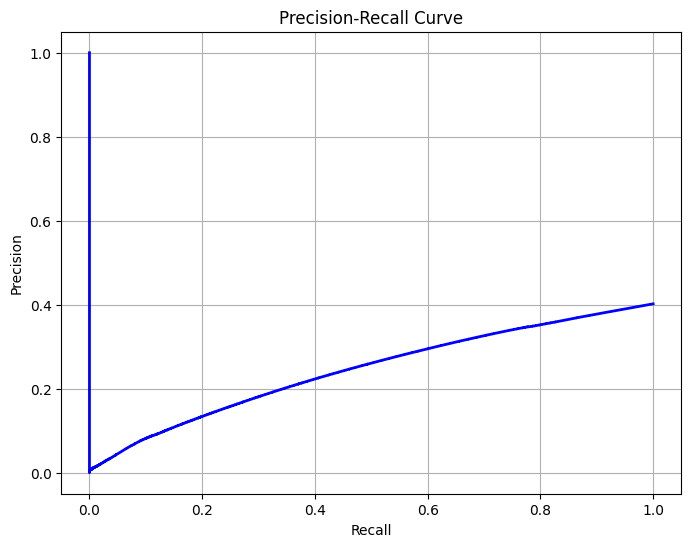

In [14]:
# Plot 1: Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_true, anomaly_scores)
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='b', linewidth=2)
plt.title('Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.grid(True)
plt.show()

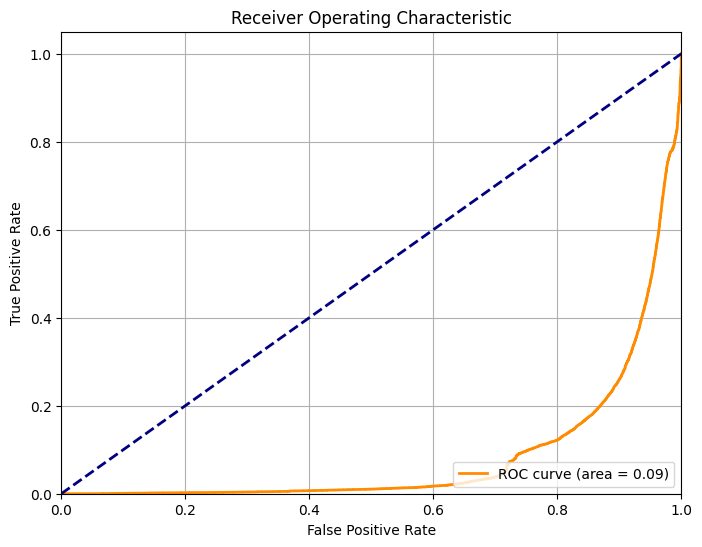

In [15]:
# Plot 2: ROC Curve
fpr, tpr, _ = roc_curve(y_true, anomaly_scores)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

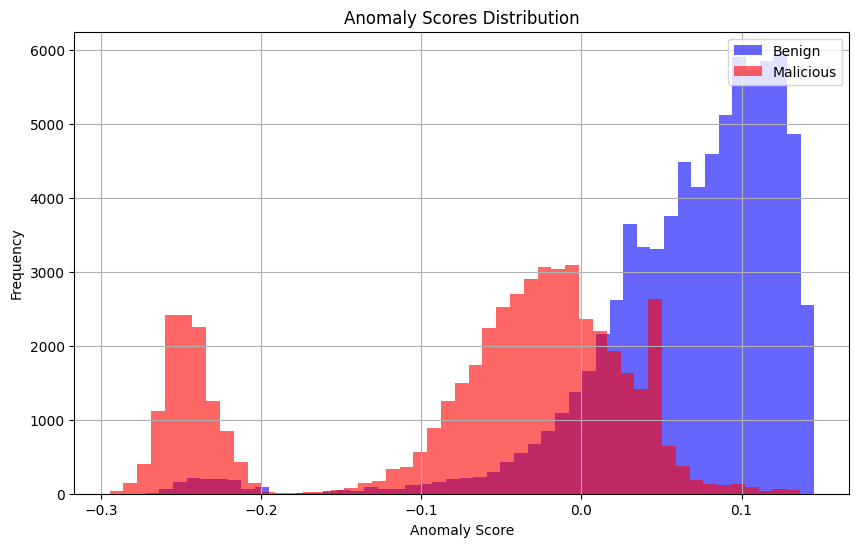

In [16]:
# Plot 3: Anomaly Scores Distribution
benign_scores = iso_forest.decision_function(X_benign)
malicious_scores = iso_forest.decision_function(X_malicious)
plt.figure(figsize=(10, 6))
plt.hist(benign_scores, bins=50, alpha=0.6, color='blue', label='Benign')
plt.hist(malicious_scores, bins=50, alpha=0.6, color='red', label='Malicious')
plt.title('Anomaly Scores Distribution')
plt.xlabel('Anomaly Score')
plt.ylabel('Frequency')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

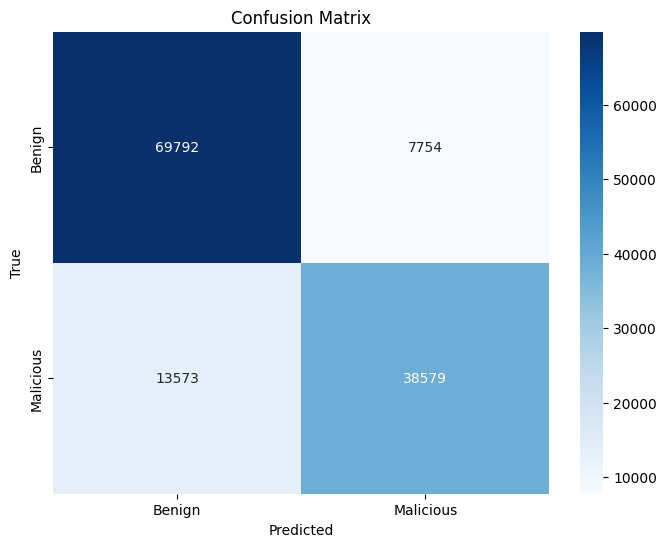

In [17]:
# Plot 4: Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Benign', 'Malicious'], yticklabels=['Benign', 'Malicious'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()